In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, chi2_contingency
from scipy.stats import zscore

import sys
sys.path.append(r"C:\Users\FernandoSanz-Extreme\OneDrive - AMCHOR INVESTMENT STRATEGIES SGIIC, S.A\Escritorio\Ironhack\DATA_OCT24_MAD")
from functions import *

pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

pd.set_option('display.max_colwidth', None)

In [34]:
#Cargamos los CSV y hacemos copia
data_company_overview = pd.read_csv("1_overview.csv")
data_balance = pd.read_csv("2_balance.csv")
data_cash_flow = pd.read_csv("3_cash_flow.csv")
data_income_statement = pd.read_csv("4_income.csv")
data_market = pd.read_csv("5_stocks.csv", sep=';')
data_ratios = pd.read_csv("6_ratios.csv")
data_balance_t = pd.read_csv("2_balance_t.csv")
data_cash_flow_t = pd.read_csv("3_cash_flow_t.csv")
data_income_statement_t = pd.read_csv("4_income_t.csv")
data_ratios_t = pd.read_csv("6_ratios_t.csv")
overview_df = data_company_overview.copy()
balance_df = data_balance.copy()
cf_df = data_cash_flow.copy()
income_df = data_income_statement.copy()
market_df = data_market.copy()
ratios_df = data_ratios.copy()
balance_t_df = data_balance_t.copy()
cf_t_df = data_cash_flow_t.copy()
income_t_df = data_income_statement_t.copy()
ratios_t_df = data_ratios_t.copy()

In [35]:
for col in ['open', 'high', 'low', 'close']:
    market_df[col] = market_df[col].str.replace(',', '.').astype(float)

In [36]:
balance_df['fiscal_date_ending'] = pd.to_datetime(balance_df['fiscal_date_ending'])
balance_t_df['fiscal_date_ending'] = pd.to_datetime(balance_t_df['fiscal_date_ending'])
market_df['date'] = pd.to_datetime(market_df['date'])

# Obtener un conjunto de fechas hábiles del mercado
market_dates = market_df['date'].sort_values().unique()

# Función para ajustar las fechas al día hábil más cercano
def closest_market_date(date, market_dates):
    if date in market_dates:
        return date
    else:
        # Buscar la fecha válida más cercana
        closest_date = min(market_dates, key=lambda x: abs(x - date))
        return closest_date

# Aplicar la función al DataFrame izquierdo
balance_df['adjusted_date'] = balance_df['fiscal_date_ending'].apply(lambda x: closest_market_date(x, market_dates))
balance_t_df['adjusted_date'] = balance_t_df['fiscal_date_ending'].apply(lambda x: closest_market_date(x, market_dates))

# Hacer el merge con las fechas ajustadas
merged_df = (
    balance_df.merge(cf_df, on=["symbol", "year"], how="inner", suffixes=("", "_dup"))
    .merge(income_df, on=["symbol", "year"], how="inner", suffixes=("", "_dup"))
    .merge(ratios_df, on=["symbol", "year"], how="inner", suffixes=("", "_dup"))
    .merge(market_df, left_on=["symbol", "adjusted_date"], right_on=["symbol", "date"], how="inner", suffixes=("", "_dup"))
)
merged_t_df = (
    balance_t_df.merge(cf_t_df, on=["symbol", "year", "quarter"], how="inner", suffixes=("", "_dup"))
    .merge(income_t_df, on=["symbol", "year", "quarter"], how="inner", suffixes=("", "_dup"))
    .merge(ratios_t_df, on=["symbol", "year"], how="inner", suffixes=("", "_dup"))
    .merge(market_df, left_on=["symbol", "adjusted_date"], right_on=["symbol", "date"], how="inner", suffixes=("", "_dup"))
)

# Identificar columnas duplicadas generadas por sufijos
columns_to_drop = [col for col in merged_df.columns if col.endswith("_dup")]
columns_to_drop_t = [col for col in merged_t_df.columns if col.endswith("_dup")]

# Dropear columnas duplicadas
merged_df = merged_df.drop(columns=columns_to_drop)
merged_t_df = merged_t_df.drop(columns=columns_to_drop)


In [37]:
# Guardar el DataFrame de ratios en un archivo CSV
merged_df.to_csv("7_merged.csv", index=False)
merged_t_df.to_csv("7_t_merged.csv", index=False)

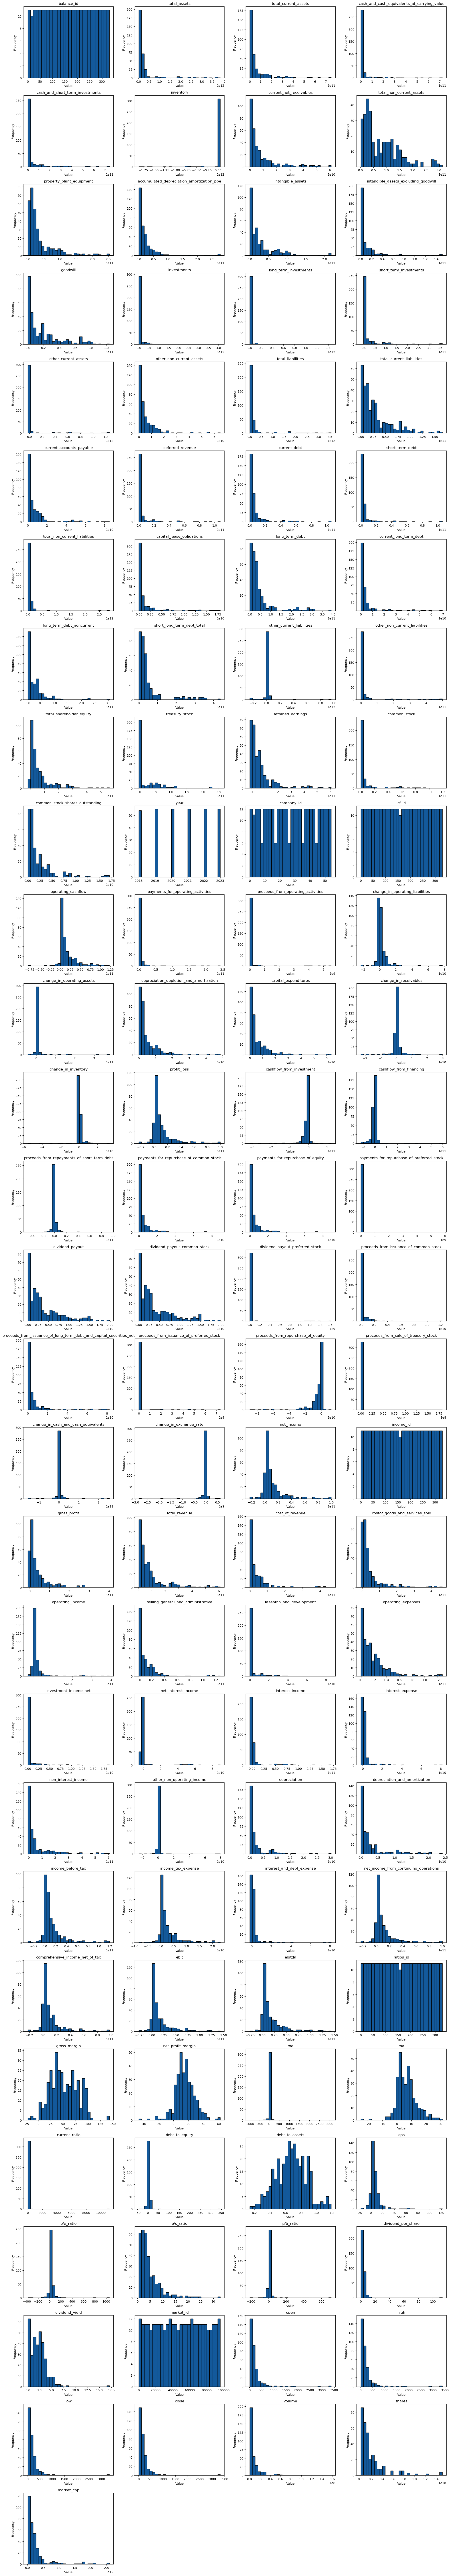

In [11]:
distribution_check(merged_df)

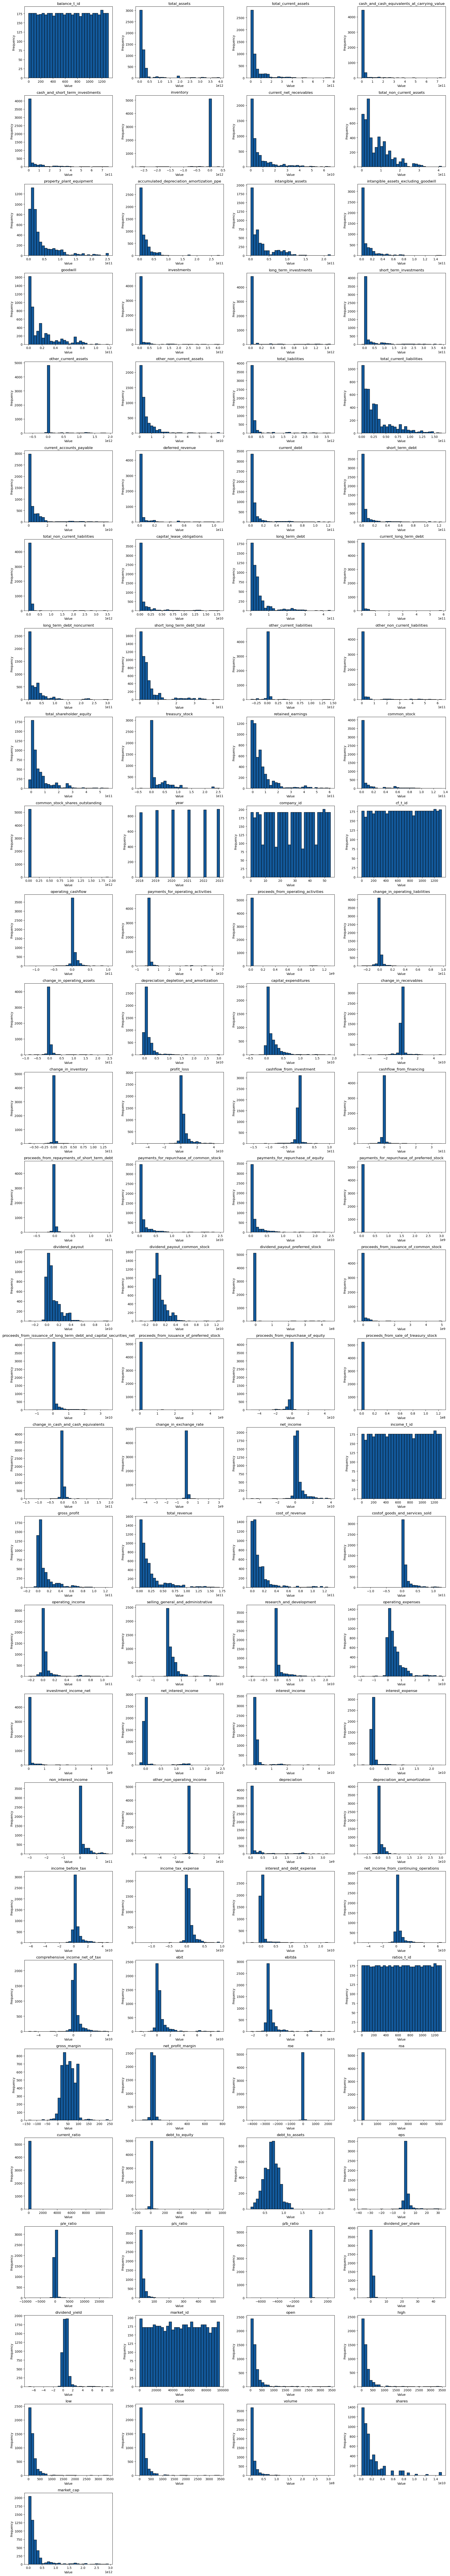

In [12]:
distribution_check(merged_t_df)

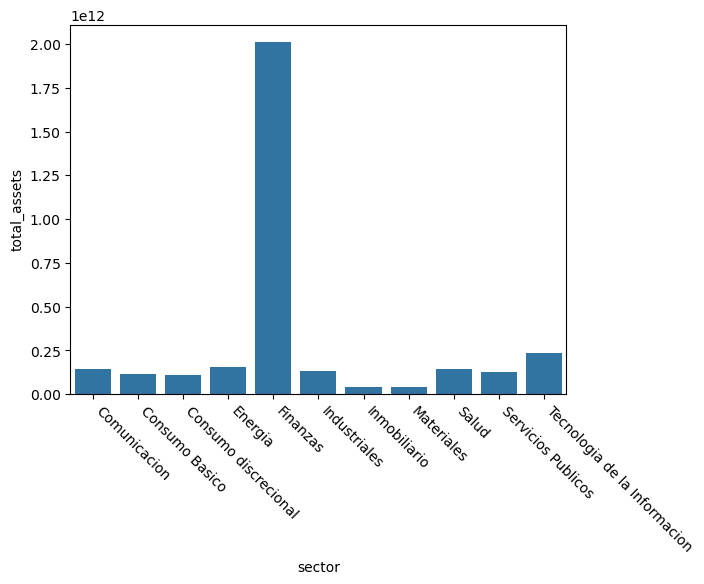

In [13]:
sns.barplot(data=merged_df, x="sector", y="total_assets", errorbar=None)
plt.xticks(rotation = -45, ha="left")
plt.show()

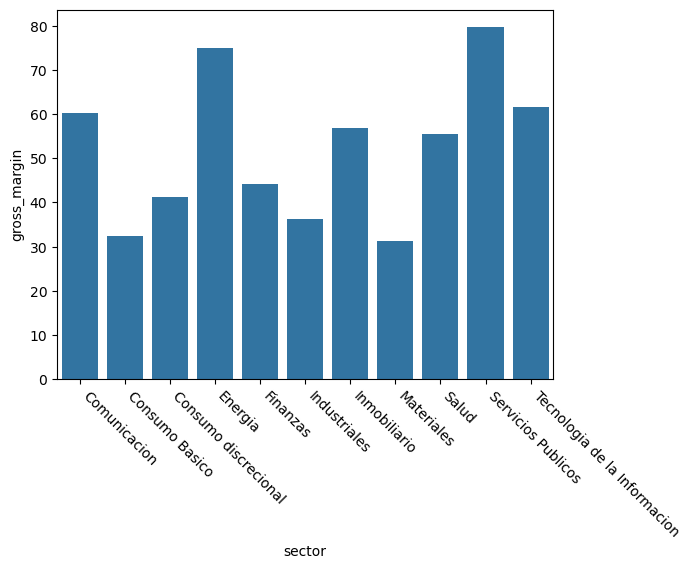

In [14]:
sns.barplot(data=merged_df, x="sector", y="gross_margin", errorbar=None)
plt.xticks(rotation = -45, ha="left")
plt.show()

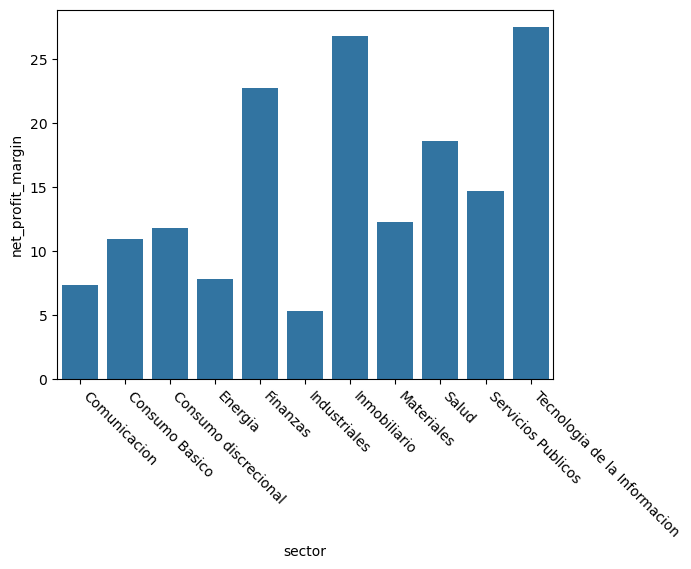

In [15]:
sns.barplot(data=merged_df, x="sector", y="net_profit_margin", errorbar=None)
plt.xticks(rotation = -45, ha="left")
plt.show()

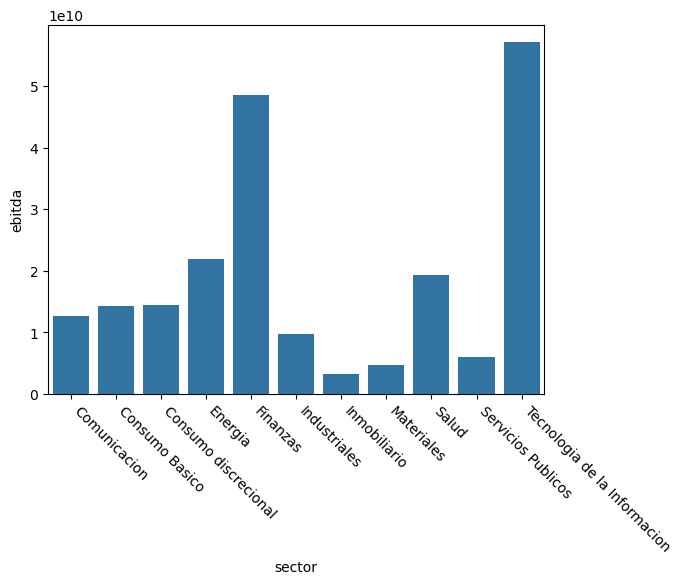

In [16]:
sns.barplot(data=merged_df, x="sector", y="ebitda", errorbar=None)
plt.xticks(rotation = -45, ha="left")
plt.show()

<h2 style="color: #008080;">One way ANOVA</h2>

<h3 style="color: #008080;">Dividends per share</h3>

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **dividends per share** based on **company sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean dividends per share between sectors.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
sectors = list(overview_df.sector.unique())
sectors

['Comunicacion',
 'Consumo Basico',
 'Consumo discrecional',
 'Energia',
 'Finanzas',
 'Industriales',
 'Inmobiliario',
 'Materiales',
 'Salud',
 'Servicios Publicos',
 'Tecnologia de la Informacion']

In [17]:
comunicacion_df = ratios_df[ratios_df['sector'] == 'Comunicacion']['dividend_per_share']
consumo_basico_df = ratios_df[ratios_df['sector'] == 'Consumo Basico']['dividend_per_share']
consumo_discrecional_df = ratios_df[ratios_df['sector'] == 'Consumo discrecional']['dividend_per_share']
energia_df = ratios_df[ratios_df['sector'] == 'Energia']['dividend_per_share']
finanzas_df = ratios_df[ratios_df['sector'] == 'Finanzas']['dividend_per_share']
industriales_df = ratios_df[ratios_df['sector'] == 'Industriales']['dividend_per_share']
inmobiliario_df = ratios_df[ratios_df['sector'] == 'Inmobiliario']['dividend_per_share']
materiales_df = ratios_df[ratios_df['sector'] == 'Materiales']['dividend_per_share']
salud_df = ratios_df[ratios_df['sector'] == 'Salud']['dividend_per_share']
servicios_publicos_df = ratios_df[ratios_df['sector'] == 'Servicios Publicos']['dividend_per_share']
tecnologia_de_la_informacion_df = ratios_df[ratios_df['sector'] == 'Tecnologia de la Informacion']['dividend_per_share']

In [18]:
print(comunicacion_df.mean())
print(consumo_basico_df.mean())
print(consumo_discrecional_df.mean())
print(energia_df.mean())
print(finanzas_df.mean())
print(industriales_df.mean())
print(inmobiliario_df.mean())
print(materiales_df.mean())
print(salud_df.mean())
print(servicios_publicos_df.mean())
print(tecnologia_de_la_informacion_df.mean())

4.324827586206896
3.196666666666666
2.5576666666666674
3.047333333333333
1.8883333333333332
2.6676666666666673
6.021666666666666
2.9110000000000005
3.4593333333333334
2.5973333333333333
0.9276666666666669


In [19]:
import scipy.stats as st

# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(comunicacion_df, consumo_basico_df, consumo_discrecional_df,energia_df,finanzas_df,industriales_df,inmobiliario_df,materiales_df,salud_df,servicios_publicos_df,tecnologia_de_la_informacion_df)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company sector has no significant impact on dividends per share.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in dividends per share based on company sector.")

F-Statistic: 1.21
P-Value: 0.2828

Fail to Reject the Null Hypothesis: Company sector has no significant impact on dividends per share.


<h3 style="color: #008080;">Net profit margin</h3>

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **net profit margin** based on **company sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean net profit margin between sectors.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [20]:
net_profit_comunicacion_df = ratios_df[ratios_df['sector'] == 'Comunicacion']['net_profit_margin']
net_profit_consumo_basico_df = ratios_df[ratios_df['sector'] == 'Consumo Basico']['net_profit_margin']
net_profit_consumo_discrecional_df = ratios_df[ratios_df['sector'] == 'Consumo discrecional']['net_profit_margin']
net_profit_energia_df = ratios_df[ratios_df['sector'] == 'Energia']['net_profit_margin']
net_profit_finanzas_df = ratios_df[ratios_df['sector'] == 'Finanzas']['net_profit_margin']
net_profit_industriales_df = ratios_df[ratios_df['sector'] == 'Industriales']['net_profit_margin']
net_profit_inmobiliario_df = ratios_df[ratios_df['sector'] == 'Inmobiliario']['net_profit_margin']
net_profit_materiales_df = ratios_df[ratios_df['sector'] == 'Materiales']['net_profit_margin']
net_profit_salud_df = ratios_df[ratios_df['sector'] == 'Salud']['net_profit_margin']
net_profit_servicios_publicos_df = ratios_df[ratios_df['sector'] == 'Servicios Publicos']['net_profit_margin']
net_profit_tecnologia_de_la_informacion_df = ratios_df[ratios_df['sector'] == 'Tecnologia de la Informacion']['net_profit_margin']

In [21]:
print(net_profit_comunicacion_df.mean())
print(net_profit_consumo_basico_df.mean())
print(net_profit_consumo_discrecional_df.mean())
print(net_profit_energia_df.mean())
print(net_profit_finanzas_df.mean())
print(net_profit_industriales_df.mean())
print(net_profit_inmobiliario_df.mean())
print(net_profit_materiales_df.mean())
print(net_profit_salud_df.mean())
print(net_profit_servicios_publicos_df.mean())
print(net_profit_tecnologia_de_la_informacion_df.mean())

7.360689655172413
10.952
11.767000000000003
7.812666666666668
22.675333333333334
5.279333333333333
26.755
12.225666666666665
18.601
14.703
27.45066666666667


In [22]:
import scipy.stats as st

# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(net_profit_comunicacion_df, net_profit_consumo_basico_df, net_profit_consumo_discrecional_df, net_profit_energia_df, net_profit_finanzas_df, net_profit_industriales_df, net_profit_inmobiliario_df, net_profit_materiales_df, net_profit_salud_df, net_profit_servicios_publicos_df, net_profit_tecnologia_de_la_informacion_df)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.30f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company sector has no significant impact on net profit margin.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in net profit margin based on company sector.")

F-Statistic: 15.01
P-Value: 0.000000000000000000000635314711

Reject the Null Hypothesis: There is a significant difference in net profit margin based on company sector.


# bivariate

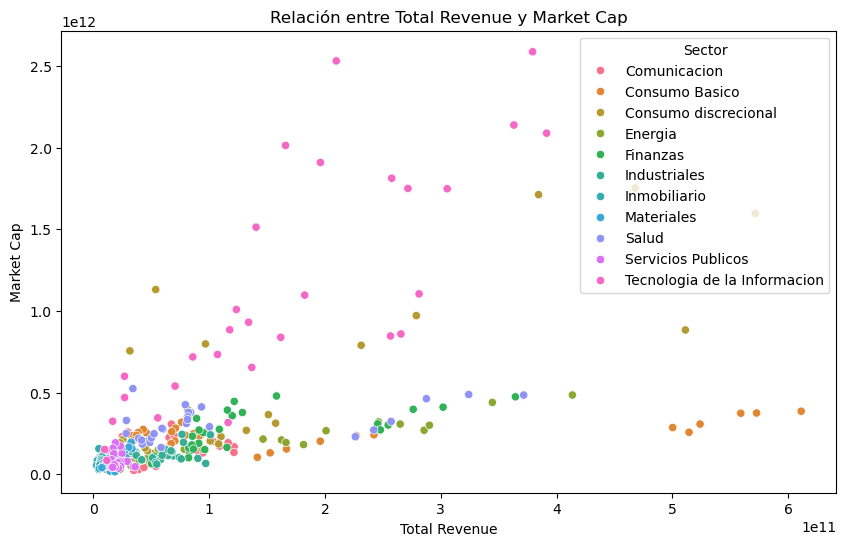

In [23]:
# 1. Relación entre dos variables numéricas: Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="total_revenue", y="market_cap", hue="sector", data=merged_df)
plt.title("Relación entre Total Revenue y Market Cap")
plt.xlabel("Total Revenue")
plt.ylabel("Market Cap")
plt.legend(title="Sector")
plt.show()

In [30]:
list(overview_df.columns)

['company_id',
 'symbol',
 'name',
 'description',
 'cik',
 'exchange',
 'industry',
 'address',
 'official_site',
 'fiscal_year_end',
 'latest_quarter',
 'market_capitalization',
 'pegratio',
 'book_value',
 'dividend_per_share',
 'dividend_yield',
 'eps',
 'revenue_per_share_ttm',
 'profit_margin',
 'operating_margin_ttm',
 'return_on_assets_ttm',
 'return_on_equity_ttm',
 'revenue_ttm',
 'gross_profit_ttm',
 'diluted_epsttm',
 'quarterly_earnings_growth_yoy',
 'quarterly_revenue_growth_yoy',
 'analyst_target_price',
 'analyst_rating_strong_buy',
 'analyst_rating_buy',
 'analyst_rating_hold',
 'analyst_rating_sell',
 'analyst_rating_strong_sell',
 'forward_pe',
 'price_to_sales_ratio_ttm',
 'evto_revenue',
 'beta',
 '52week_high',
 '52week_low',
 '50day_moving_average',
 '200day_moving_average',
 'shares_outstanding',
 'sector',
 'state']

In [ ]:
mer